## Imports

In [48]:
import pyxdf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from lmfit.models import ExponentialModel, Model

## Function Definitions

Predicted pupil dilation, $d(Y)$, caused by luminance $Y$, is computed with the following equation: $𝑑(𝑌) = 𝑎 · 𝑒^{−𝑏·𝑌} + c$

In [49]:
def pupil_func(x, a, b, c):
    return a * np.exp(-b * x) + c

## Load Data

Load the data from the xdf file for a single participant.

In [50]:
streams, header = pyxdf.load_xdf('./Path_Data/ID_111.xdf')

for stream in streams:
    print(np.array(stream['time_series']).shape)
    print(stream['info']['name'][0])

dfs = {}
for stream in streams:
    stream_name = stream['info']['name'][0]
    stream_channels = {}
    for i, channels in enumerate(stream['info']['desc'][0]['channels'][0]['channel']):
        stream_channels[channels['label'][0]] = i
    stream_data = stream['time_series']
    #example of data layout
    #stream_name: LuminanceStream
    #stream_channels: {'UserID': 0, 'BlockID': 1, 'ModelID': 2, 'MethodID': 3, 'Luminance': 4}
    #stream_data: [[1.0000000e+02 0.0000000e+00 9.9000000e+01 9.9000000e+01 1.1425743e-02][1.0000000e+02 0.0000000e+00 9.9000000e+01 9.9000000e+01 1.1425743e-02][1.0000000e+02 0.0000000e+00 9.9000000e+01 9.9000000e+01 1.1425743e-02]
    data_dict= {}
    for key in stream_channels.keys():
        data_dict[key] = np.array(stream_data)[:, stream_channels[key]]
    time_stamps = np.array(stream['time_stamps'])
    for i in range(len(time_stamps)):
        time_stamps[i] = round(time_stamps[i], 4)
    data_dict['time'] = time_stamps
    dfs[stream_name] = pd.DataFrame(data_dict)
    dfs[stream_name].drop_duplicates(subset=['time'], keep='first', inplace=True)
    dfs[stream_name].reset_index(drop=True, inplace=True)

(27, 6)
SurveyStream
(64, 7)
CreationStream
(118545, 17)
GazeStream
(118503, 5)
LuminanceStream
(114443, 25)
PoseStream
(82, 6)
ExperimentStream
(44186, 10)
NavigationStream
(114443, 25)
TrackedPoseStream


In [51]:
accom_time = pd.to_timedelta(0.5, unit='s')

pupil = dfs['GazeStream'].loc[(dfs['GazeStream']['LeftEyeIsBlinking'] == 0) & (dfs['GazeStream']['RightEyeIsBlinking'] == 0) & (dfs['GazeStream']['LeftPupilDiameter'] > 0) & (dfs['GazeStream']['RightPupilDiameter'] > 0), ['time', 'MethodID', 'ModelID', 'LeftPupilDiameter', 'RightPupilDiameter']]
pupil['time'] = pd.to_timedelta(pupil['time'], unit='s')

lum = dfs['LuminanceStream'].loc[:, ['time', 'MethodID', 'ModelID', 'Luminance']]
lum['time'] = pd.to_timedelta(lum['time'], unit='s')

# Intersection of time stamps
pupil_lum_time_intersection = np.intersect1d(pupil['time'], lum['time'])

# Filter pupil and luminance data by intersection
pupil = pupil[pupil['time'].isin(pupil_lum_time_intersection)].reset_index(drop=True)
lum = lum[lum['time'].isin(pupil_lum_time_intersection)].reset_index(drop=True)

# Combined DataFrame for pupil and luminance
pup_lum_df = pd.DataFrame({
    'time': pd.to_timedelta(lum['time'], unit='s'),
    'luminance': lum['Luminance'],
    'pupilDiameter': 0.5 * (pupil['LeftPupilDiameter'] + pupil['RightPupilDiameter']),
    'methodID': pupil['MethodID'],
    'modelID': pupil['ModelID']
}).resample('0.1s', on='time').mean()

pup_lum_df['time'] = pup_lum_df.index

# Calibration data 
calibration_events = dfs['ExperimentStream'].loc[(dfs['ExperimentStream']['EventType'] == 'CalibrationColorChange') | (dfs['ExperimentStream']['SceneEvent'] == 'Calibration') | (dfs['ExperimentStream']['SceneEvent'] == 'CalibrationComplete'), ['time','SceneEvent', 'EventType']]
calibration_events['time'] = pd.to_timedelta(calibration_events['time'], unit='s')

start_times = calibration_events[:8]['time']
end_times = calibration_events[1:]['time']
start_times = start_times.reset_index(drop=True)
end_times = end_times.reset_index(drop=True)

pupil_calib = pup_lum_df.loc[(pup_lum_df['methodID'] > 98.0), ['pupilDiameter']]
lum_calib = pup_lum_df.loc[(pup_lum_df['methodID'] > 98.0), ['luminance']]

calib_data = {}
for i in range(8):
    calib_data[i] = pup_lum_df.loc[(pup_lum_df['time'] >= start_times[i]) & (pup_lum_df['time'] <= end_times[i]), ['time','luminance', 'pupilDiameter']]
    calib_data[i]['time'] -= calib_data[i]['time'].iloc[0]
    calib_data[i] = calib_data[i].loc[(calib_data[i]['time'] >= accom_time), ['luminance', 'pupilDiameter']]

calibration_data = pd.concat(calib_data).groupby(level=0).mean().sort_values(by=['luminance']).reset_index(drop=True)

In [52]:
calib_data = {}
for i in range(8):
    if i == 7:
        calib_data[i] = pup_lum_df.loc[(pup_lum_df['time']>=calibration_events.loc[i, 'time']) & (pup_lum_df['time']<=pupil_calib['time'].iloc[-1]), ['time', 'Luminance', 'pupilDiameter']]
    else:
        calib_data[i] = pup_lum_df.loc[(pup_lum_df['time']>=calibration_events.loc[i, 'time']) & (pup_lum_df['time']<=calibration_events.loc[i+1, 'time']), ['time', 'Luminance', 'pupilDiameter']]

for i in range(8):
    calib_data[i].reset_index(drop=True, inplace=True)
    calib_data[i]['time'] = calib_data[i]['time'] - calib_data[i]['time'][0]
    calib_data[i]=calib_data[i].loc[(calib_data[i]['time']>=accom_time), ['time', 'Luminance', 'pupilDiameter']]
    calib_data[i].reset_index(drop=True, inplace=True)

calibration_data = pd.concat(calib_data)
calibration_data.drop(columns=['time'], inplace=True)
calibration_data.reset_index(level=1, drop=True, inplace=True)
calibration_data = calibration_data.groupby(level=0).mean()
calibration_data.sort_values(by=['Luminance'], inplace=True)
calibration_data.reset_index(drop=True, inplace=True)
print(calibration_data)


KeyError: 0

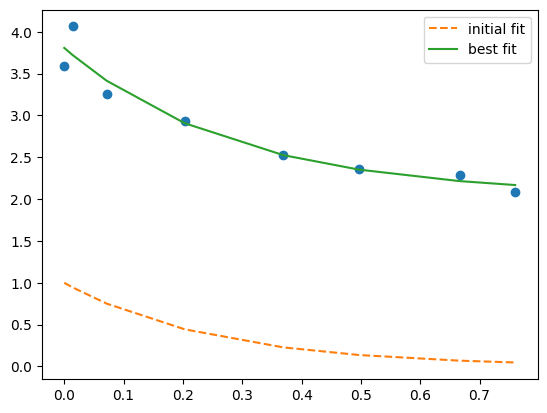

In [ ]:
#𝑎, 𝑏, and 𝑐 were fitted using least squares optimization with empirically determined bounds of a: [1, 4], b: [4, 8], and c: [0, 8]
x_data = calibration_data['luminance']
y_data = calibration_data['pupilDiameter']

exp_mod = Model(pupil_func)
params = exp_mod.make_params(a=1, b=4, c=0)

result = exp_mod.fit(y_data, params, x=x_data)
a = result.params['a'].value
b = result.params['b'].value
c = result.params['c'].value

plt.plot(x_data, y_data, 'o')
plt.plot(x_data, result.init_fit, '--', label='initial fit')
plt.plot(x_data, result.best_fit, '-', label='best fit')
plt.legend()
plt.show()

In [64]:
navigation_events = dfs['ExperimentStream'].loc[(dfs['ExperimentStream']['SceneEvent'] == 'NavigationComplete') | (dfs['ExperimentStream']['SceneEvent'] == 'Navigation_Trial'), ['time','SceneEvent', 'EventType', 'ModelID', 'MethodID']]
navigation_events.reset_index(drop=True, inplace=True)
navigation_events['time'] = pd.to_timedelta(navigation_events['time'], unit='s')
start_times = navigation_events.loc[navigation_events['SceneEvent'] == 'Navigation_Trial', 'time']
start_times.reset_index(drop=True, inplace=True)
end_times = navigation_events.loc[navigation_events['SceneEvent'] == 'NavigationComplete', 'time']
end_times.reset_index(drop=True, inplace=True)

nav_data = {}
for i in range(8):
    nav_data[i] = pup_lum_df.loc[(pup_lum_df['time']>=start_times.loc[i]) & (pup_lum_df['time']<=end_times.loc[i]), ['time', 'methodID', 'modelID', 'luminance', 'pupilDiameter']]
    nav_data[i].set_index('time', inplace=True, drop=False)

navigation_data = pd.concat(nav_data, names=['trial'])
navigation_data = navigation_data.groupby(level=0).resample('0.5s', on='time', ).mean()
navigation_data['plr'] = pupil_func(navigation_data['luminance'], a, b, c)
navigation_data['tepr'] = navigation_data['pupilDiameter'] - navigation_data['plr']

navigation_avg = navigation_data.groupby(level=0).mean()
navigation_avg.drop(columns=['luminance'], inplace=True)

models = navigation_avg.reset_index(drop=True)
model_avg = models.groupby(['modelID']).mean()
model_avg.drop(columns=['methodID'], inplace=True)

methods = navigation_avg.reset_index(drop=True)
method_avg = methods.groupby(['methodID']).mean()
method_avg.drop(columns=['modelID'], inplace=True)
params = pd.DataFrame({'params': [a, b, c]}, index=['a', 'b', 'c'])
p = {'a': a, 'b': b, 'c': c}
test = []
id = []
user_data = pd.concat([model_avg, method_avg], keys=['modelID', 'methodID'], names=['Group'])
d2 = user_data
id.append('108')
id.append('111')
test.append(user_data)
test.append(d2)

df = pd.concat(test, keys=id, names=['UserID'])
print(df)


                     pupilDiameter       plr      tepr
UserID Group                                          
108    modelID  0.0       3.822796  2.916256  0.906540
                1.0       3.790428  2.971191  0.819237
                2.0       3.614001  2.811214  0.802786
                3.0       3.610395  2.876311  0.734085
       methodID 2.0       3.563311  2.852220  0.711092
                3.0       3.855499  2.935266  0.920232
111    modelID  0.0       3.822796  2.916256  0.906540
                1.0       3.790428  2.971191  0.819237
                2.0       3.614001  2.811214  0.802786
                3.0       3.610395  2.876311  0.734085
       methodID 2.0       3.563311  2.852220  0.711092
                3.0       3.855499  2.935266  0.920232


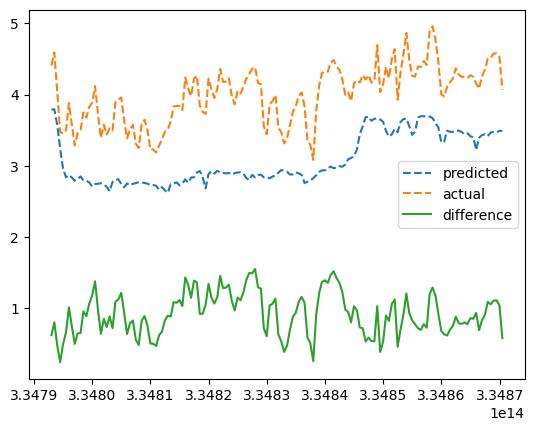

In [ ]:
idx = 1

for i in range(8):
    nav_data[i] = nav_data[i].resample('0.5s', origin='start').mean()

lum_nav = nav_data[idx]['Luminance']
pupil_nav = nav_data[idx]['pupilDiameter']

plr = pd.DataFrame(pupil_func(lum_nav, a, b, c))
plr['time'] = plr.index
plr.rename(columns={"Luminance": "pupilDiameter"}, inplace=True)
plr.reset_index(drop=True, inplace=True)

predicted_plr = pd.DataFrame(columns=['pupilDiameter'])
for t in range(len(plr)):
    if t==0:
        predicted_plr.loc[t, "pupilDiameter"] = plr.loc[t,'pupilDiameter']
    else:
        predicted_plr.loc[t, "pupilDiameter"] = plr.loc[t-1,'pupilDiameter']
predicted_plr['time'] = plr['time']
predicted_plr.set_index('time', inplace=True)

plot_dif = pupil_nav - predicted_plr['pupilDiameter']

x_data = pupil_nav.index

plt.plot(x_data, predicted_plr['pupilDiameter'], '--', label='predicted')
plt.plot(x_data, pupil_nav, '--', label='actual')
plt.plot(x_data, plot_dif, '-', label='difference')
plt.legend()
